## Packages installations

In [1]:
# Install the packages
! pip install --upgrade google-genai google-cloud-storage requests matplotlib pillow tqdm tenacity

! pip install google-cloud-vision


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

## Parameters

In [3]:
PROJECT = !gcloud config get-value project
PROJECT_ID = PROJECT[0]
REGION = "us-central1"

## Build Infra

In [4]:
BUCKET_URI = f"gs://artifacts-{PROJECT_ID}-unique"  # @param {type:"string"}
print(f"Creating GS bucket: {BUCKET_URI}")

! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

Creating GS bucket: gs://artifacts-qwiklabs-gcp-01-76ef03e04b4d-unique
Creating gs://artifacts-qwiklabs-gcp-01-76ef03e04b4d-unique/...
ServiceException: 409 A Cloud Storage bucket named 'artifacts-qwiklabs-gcp-01-76ef03e04b4d-unique' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


## Download data from DiffusionDB dataset

You'll use DiffusionDB dataset of image prompt and image pairs.

In [5]:
! git clone https://github.com/poloclub/diffusiondb

! pip install -r diffusiondb/requirements.txt

# Download image files from 1. The file contains of 1000 images.
! python diffusiondb/scripts/download.py -i 2 -r 3

fatal: destination path 'diffusiondb' already exists and is not an empty directory.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [6]:
# Unzip all image files
image_directory = "extracted"

! unzip -n 'images/*.zip' -d '{image_directory}'

Archive:  images/part-000002.zip


## Get images metadata

In [7]:
import json
import os

metadatas = {}
for file_name in os.listdir(image_directory):
    if file_name.endswith(".json"):
        with open(os.path.join(image_directory, file_name)) as f:
            metadata_chunk = json.load(f)
            metadatas.update(metadata_chunk)

# Get image names and paths from the loaded metadata
image_names_all = list(metadatas.keys())
image_paths_all = [os.path.join(image_directory, image_name) for image_name in image_names_all]

len(metadatas)

1000

## Detect Explicit Images

et's now define a function to query the Cloud Vision API to detect potential explicit images. Learn more about content detection (SafeSearch) in [Detect explicit content](https://cloud.google.com/vision/docs/detecting-safe-search).

In [8]:
from typing import Optional

from google.cloud import vision
from google.cloud.vision_v1.types.image_annotator import SafeSearchAnnotation
from google.cloud.vision_v1.types.image_annotator import Likelihood


def detect_safe_search(path: str) -> Optional[SafeSearchAnnotation]:
    """Detects unsafe features in the file."""

    with open(path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.safe_search_detection(image=image)

    if response.error.message:
        print(response.error.message)
        return None

    return response.safe_search_annotation


def convert_annotation_to_safety(safe_search_annotation: SafeSearchAnnotation) -> bool:
    """Returns true if some annotations have a potential safety issues"""
    return all(
        [
            (safe_level == Likelihood.VERY_UNLIKELY)
            or (safe_level == Likelihood.UNLIKELY)
            for safe_level in [
                safe_search_annotation.adult,
                safe_search_annotation.medical,
                safe_search_annotation.violence,
                safe_search_annotation.racy,
            ]
        ]
    )


def process_image(image_path: str) -> Optional[bool]:
    try:
        annotation = detect_safe_search(image_path)

        if annotation:
            return convert_annotation_to_safety(safe_search_annotation=annotation)
        else:
            return None
    except Exception:
        return None

In [9]:
# Process images 
# - Use a rate limiter to ensure the requests go under this limit. 
# - For better performance, use a ThreadPool to make parallel requests.

import time
from concurrent.futures import ThreadPoolExecutor
from typing import Optional

import numpy as np
from tqdm import tqdm

# Client for vision API
client = vision.ImageAnnotatorClient()

# Create a rate limiter with a limit of 1800 requests per minute
seconds_per_job = 1 / (1800 / 60)


# Process images using ThreadPool
is_safe_values_cloud_vision = []
with ThreadPoolExecutor() as executor:
    futures = []
    for img_url in tqdm(image_paths_all, total=len(image_paths_all), position=0):
        futures.append(executor.submit(process_image, img_url))
        time.sleep(seconds_per_job)

    for future in futures:
        is_safe_values_cloud_vision.append(future.result())

# Set Nones to False
is_safe_values_cloud_vision = [
    is_safe or False for is_safe in is_safe_values_cloud_vision
]

# Print number of safe images found
print(
    f"Safe images = {np.array(is_safe_values_cloud_vision).sum()} out of {len(is_safe_values_cloud_vision)} images"
)

100%|██████████| 1000/1000 [00:34<00:00, 29.14it/s]


Safe images = 711 out of 1000 images


In [10]:
# Filter images by safety
metadatas = [
    metadata
    for metadata, is_safe in zip(metadatas, is_safe_values_cloud_vision)
    if is_safe
]
image_names = [
    image_name
    for image_name, is_safe in zip(image_names_all, is_safe_values_cloud_vision)
    if is_safe
]
image_paths = [
    image_path
    for image_path, is_safe in zip(image_paths_all, is_safe_values_cloud_vision)
    if is_safe
]

## Defining encoding functions

Create an EmbeddingPredictionClient which encapsulates the logic to call the embedding API.

In [11]:
import base64
import time
import typing
import requests # Make sure requests is imported
import numpy as np

from google.cloud import aiplatform
from google.protobuf import struct_pb2


class EmbeddingResponse(typing.NamedTuple):
    text_embedding: typing.Sequence[float]
    image_embedding: typing.Sequence[float]


def load_image_bytes(image_uri: str) -> bytes:
    """Load image bytes from a local URI."""
    # This lab only uses local files, so simplify.
    with open(image_uri, "rb") as image_file:
        image_bytes = image_file.read()
    return image_bytes


class EmbeddingPredictionClient:
    """Wrapper around Prediction Service Client."""

    def __init__(
        self,
        project: str,
        location: str = "us-central1",
        api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com",
    ):
        client_options = {"api_endpoint": api_regional_endpoint}
        self.client = aiplatform.gapic.PredictionServiceClient(
            client_options=client_options
        )
        self.location = location
        self.project = project

    def get_embedding(self, text: str = None, image_file: str = None):
        if not text and not image_file:
            raise ValueError("At least one of text or image_file must be specified.")

        # Load image file if provided
        image_bytes = None
        if image_file:
            image_bytes = load_image_bytes(image_file)

        instance = struct_pb2.Struct()
        if text:
            instance.fields["text"].string_value = text

        if image_bytes:
            encoded_content = base64.b64encode(image_bytes).decode("utf-8")
            image_struct = instance.fields["image"].struct_value
            image_struct.fields["bytesBase64Encoded"].string_value = encoded_content

        instances = [instance]
        endpoint = (
            f"projects/{self.project}/locations/{self.location}"
            "/publishers/google/models/multimodalembedding@001"
        )
        response = self.client.predict(endpoint=endpoint, instances=instances)

        text_embedding = None
        if text:
            # Check if textEmbedding field exists and is not None
            if "textEmbedding" in response.predictions[0] and response.predictions[0]["textEmbedding"]:
                text_emb_value = response.predictions[0]["textEmbedding"]
                text_embedding = [v for v in text_emb_value]


        image_embedding = None
        if image_bytes:
            # Check if imageEmbedding field exists and is not None
            if "imageEmbedding" in response.predictions[0] and response.predictions[0]["imageEmbedding"]:
                image_emb_value = response.predictions[0]["imageEmbedding"]
                image_embedding = [v for v in image_emb_value]

        return EmbeddingResponse(
            text_embedding=text_embedding, image_embedding=image_embedding
        )

## Create helper functions to process data in batches
Datasets can be large, so it's recommended to load a batch of data at a time into memory using a generator.

In [12]:
import time
from concurrent.futures import ThreadPoolExecutor
from typing import Callable, Generator, List, Optional
from tqdm.auto import tqdm # Use tqdm.auto for notebook compatibility
from tenacity import retry, stop_after_attempt, wait_fixed # Import wait_fixed

def generate_batches(
    inputs: List[str], batch_size: int
) -> Generator[List[str], None, None]:
    """
    Generator function that takes a list of strings and a batch size, and yields batches of the specified size.
    """
    for i in range(0, len(inputs), batch_size):
        yield inputs[i : i + batch_size]

ACTUAL_API_RATE_RPM = 10
API_ITEMS_PER_SECOND = ACTUAL_API_RATE_RPM / 60

def encode_to_embeddings_chunked(
    process_function: Callable[[List[str]], List[Optional[List[float]]]],
    items: List[str],
    batch_size: int = 1, # Multimodal embedding model currently supports batch_size=1
) -> List[Optional[List[float]]]:
    """
    Function that encodes a list of strings (or image paths) into embeddings using a process function.
    It takes a list of items and returns a list of optional lists of floats.
    The data is processed in chunks with rate limiting.
    """
    embeddings_list: List[Optional[List[float]]] = []

    # Prepare the batches using a generator (batch size is 1 for this model)
    batches = generate_batches(items, batch_size)

    # Calculate sleep time between batches based on the *actual* API rate
    seconds_per_batch = batch_size / API_ITEMS_PER_SECOND if API_ITEMS_PER_SECOND > 0 else 0 # Avoid division by zero

    print(f"Processing {len(items)} items in batches of {batch_size}...")
    print(f"Rate limit: {ACTUAL_API_RATE_RPM} RPM ({API_ITEMS_PER_SECOND:.2f} req/sec)")
    print(f"Sleeping for {seconds_per_batch:.2f} seconds between batches.")


    with ThreadPoolExecutor(max_workers=5) as executor: # Limit concurrent workers
        futures = []
        # Use tqdm for progress bar
        for batch in tqdm(batches, total=len(items) // batch_size + (len(items) % batch_size > 0), desc="Encoding Batches"):
            # Note: The multimodalembedding model often processes 1 item per request
            # The batch argument here is typically a list of length 1 for this model.
            futures.append(executor.submit(process_function, batch))
            time.sleep(seconds_per_batch) # Respect the rate limit

        # Collect results
        for future in tqdm(futures, desc="Collecting Results"):
            embeddings_list.extend(future.result())

    return embeddings_list

### Create functions that wrap embedding functions in try-except and retry logic

This particular embedding model can only process 1 image at a time, so inputs are validated to be equal to a length of 1.

In [13]:
import copy
from typing import List, Optional

@retry(reraise=True, stop=stop_after_attempt(3), wait=wait_fixed(5))
def encode_texts_to_embeddings_with_retry(text: List[str]) -> List[List[float]]:
    # Assert that the input list has only one item, as required by the function
    assert len(text) == 1, "encode_texts_to_embeddings_with_retry expects a list with a single text item."

    try:
        # Call the embedding client for a single text input
        embedding_response = client.get_embedding(text=text[0], image_file=None)
        if embedding_response.text_embedding is None:
            # This might happen if the API didn't return a text embedding for some reason
            print(f"Warning: No text embedding returned for text: {text[0]}")
            return [None]
        return [list(embedding_response.text_embedding)] # Return as List[List[float]]
    except Exception as e:
        # Catch specific API errors if needed, but general exception is okay for lab
        print(f"Error getting text embedding for '{text[0]}': {e}")
        raise RuntimeError(f"Error getting text embedding: {e}") # Re-raise to trigger retry

def encode_texts_to_embeddings(text: List[str]) -> List[Optional[List[float]]]:
    # This function handles the retry wrapper and returns [None] on final failure
    if not text:
        return []
    try:
        results = []
        for t in text:
            # Note: We call encode_texts_to_embeddings_with_retry with a list containing one item
            embedding_result = encode_texts_to_embeddings_with_retry(text=[t])
            results.extend(embedding_result) # extend because retry returns a list of results
        return results
    except Exception as ex:
        print(f"Failed after retries for texts: {text}. Error: {ex}")
        return [None for _ in range(len(text))] # Return None for all inputs on final failure


@retry(reraise=True, stop=stop_after_attempt(3), wait=wait_fixed(5))
def encode_images_to_embeddings_with_retry(image_uris: List[str]) -> List[List[float]]:
    # Assert that the input list has only one item, as required by the function
    assert len(image_uris) == 1, "encode_images_to_embeddings_with_retry expects a list with a single image uri."

    try:
        # Call the embedding client for a single image input
        embedding_response = client.get_embedding(text=None, image_file=image_uris[0])
        if embedding_response.image_embedding is None:
            # This might happen if the API didn't return an image embedding for some reason
            print(f"Warning: No image embedding returned for image: {image_uris[0]}")
            return [None]
        return [list(embedding_response.image_embedding)] # Return as List[List[float]]
    except Exception as ex:
        print(f"Error getting image embedding for '{image_uris[0]}': {ex}")
        raise RuntimeError(f"Error getting image embedding: {ex}") # Re-raise to trigger retry


def encode_images_to_embeddings(image_uris: List[str]) -> List[Optional[List[float]]]:
    # This function handles the retry wrapper and returns [None] on final failure
    if not image_uris:
        return []
    try:
        results = []
        for uri in image_uris:
            # Note: We call encode_images_to_embeddings_with_retry with a list containing one item
            embedding_result = encode_images_to_embeddings_with_retry(image_uris=[uri])
            results.extend(embedding_result) # extend because retry returns a list of results
        return results
    except Exception as ex:
        print(f"Failed after retries for image URIs: {image_uris}. Error: {ex}")
        return [None for _ in range(len(image_uris))] # Return None for all inputs on final failure

## Test the encoding function
- Encode a subset of data and see if the embeddings and distance metrics make sense.

- Since there is no public paper describing the embedding model, assume that the embeddings are trained using cosine similarity as a loss function since that is quite common.

In [14]:
# Initialize the client here after defining the class
client = EmbeddingPredictionClient(project=PROJECT_ID, location=REGION)

In [15]:
%%time
# Encode a SAMPLE subset of images for testing.
TEST_SAMPLE_SIZE = 50
image_paths_test_sample = list(image_paths_all)[:TEST_SAMPLE_SIZE]

print(f"Encoding a test sample of {TEST_SAMPLE_SIZE} images...")

# Use the chunked encoder which includes the rate limiter
image_embeddings_test = encode_to_embeddings_chunked(
    process_function=encode_images_to_embeddings,
    items=image_paths_test_sample,
    batch_size=1 # Multimodal embedding model requires batch size 1
)

# Keep only non-None embeddings from the test sample
indexes_to_keep_test, image_embeddings_test_filtered = zip(
    *[
        (index, embedding)
        for index, embedding in enumerate(image_embeddings_test)
        if embedding is not None
    ]
) if any(e is not None for e in image_embeddings_test) else ([], []) # Handle case where all are None


print(f"Processed {len(image_embeddings_test_filtered)} test embeddings successfully")
if len(image_embeddings_test_filtered) > 0:
    print(f"First test embedding dimension: {len(image_embeddings_test_filtered[0])}")
else:
    print("No test embeddings were successfully generated.")

Encoding a test sample of 50 images...
Processing 50 items in batches of 1...
Rate limit: 10 RPM (0.17 req/sec)
Sleeping for 6.00 seconds between batches.


Encoding Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Processed 50 test embeddings successfully
First test embedding dimension: 1408
CPU times: user 1.03 s, sys: 302 ms, total: 1.33 s
Wall time: 5min


Compute similarity

In [16]:
import numpy as np

def dot_product_distance(
    text_embedding: np.ndarray, image_embeddings: np.ndarray
) -> np.ndarray:
    """Compute dot-product distance between text and image embeddings by taking the dot product"""
    # Ensure inputs are numpy arrays
    text_embedding = np.asarray(text_embedding)
    image_embeddings = np.asarray(image_embeddings)

    if text_embedding.ndim == 1:
        text_embedding = text_embedding.reshape(1, -1)

    if image_embeddings.ndim == 1:
        image_embeddings = image_embeddings.reshape(1, -1)
    elif image_embeddings.ndim > 2:
        raise ValueError("image_embeddings must be 1D or 2D array.")

    distances = np.dot(text_embedding, image_embeddings.T).squeeze()

    return np.atleast_1d(distances)

create a visualization to display the top images based on their distances from a given text query.

Successfully generated embedding for query: 'Birds in flight'
Calculating distances for 50 test embeddings.


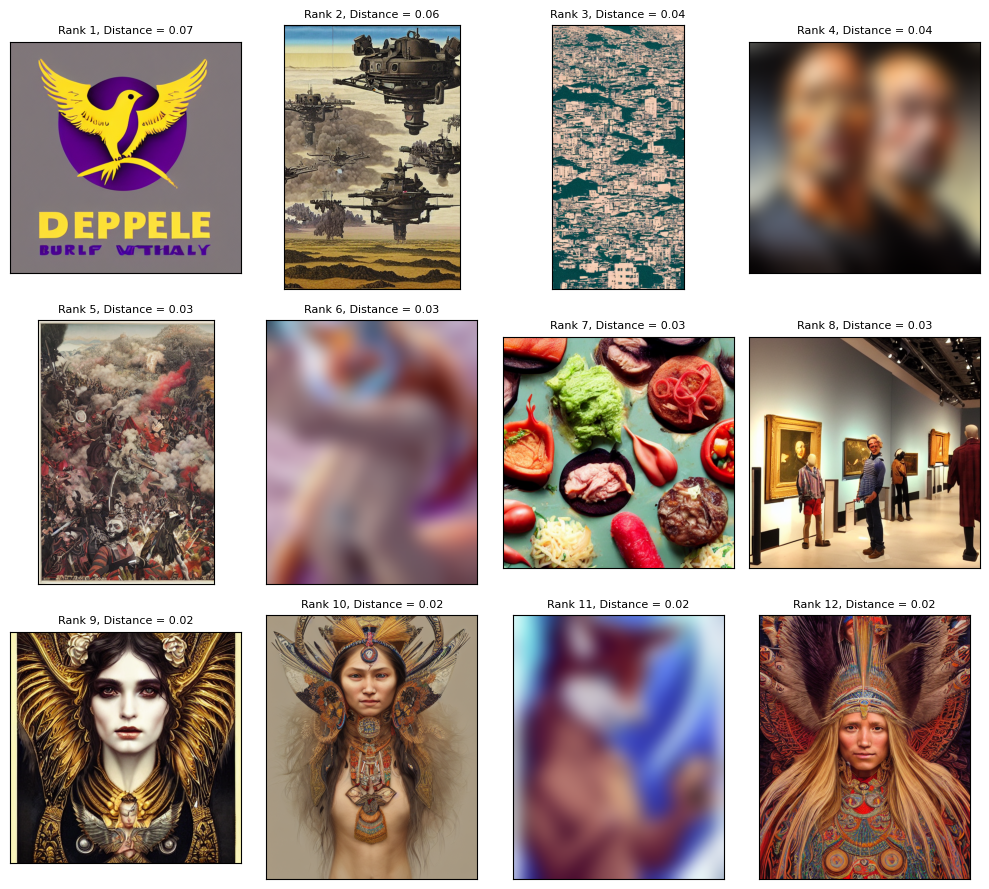

In [17]:
import math
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image # Import Image

text_query = "Birds in flight"

# Calculate text embedding of query (uses 1 API call)
text_embedding_query_list = encode_texts_to_embeddings(text=[text_query])

if not text_embedding_query_list or text_embedding_query_list[0] is None:
    print(f"Failed to get embedding for query: '{text_query}'. Cannot perform search.")
else:
    text_embedding_query = text_embedding_query_list[0]
    print(f"Successfully generated embedding for query: '{text_query}'")

    if len(image_embeddings_test_filtered) > 0:
        print(f"Calculating distances for {len(image_embeddings_test_filtered)} test embeddings.")
        distances = dot_product_distance(
            text_embedding=np.array(text_embedding_query),
            image_embeddings=np.array(image_embeddings_test_filtered) # Use the filtered test embeddings
        )

        image_paths_test_filtered = [image_paths_test_sample[i] for i in indexes_to_keep_test]

        MAX_IMAGES_DISPLAY = 12

        sorted_data = sorted(
            zip(image_paths_test_filtered, distances), key=lambda x: x[1], reverse=True
        )[:MAX_IMAGES_DISPLAY]

        # Calculate the number of rows and columns needed to display the images
        num_cols_display = 4
        num_rows_display = math.ceil(len(sorted_data) / num_cols_display)


        # Create a grid of subplots to display the images
        fig, axs = plt.subplots(nrows=num_rows_display, ncols=num_cols_display, figsize=(10, num_rows_display * 3))
        axs = axs.flatten() # Flatten the 2D array of axes for easy iteration

        # Loop through the top images and display them
        for i, (image_path, distance) in enumerate(sorted_data):
            ax = axs[i] # Get the current axis

            try:
                # Load image - we know these are local files
                image = Image.open(image_path).convert('RGB') # Convert to RGB to handle grayscale/palette

                # Display the image
                ax.imshow(image)

                # Set the title
                ax.set_title(f"Rank {i+1}, Distance = {distance:.2f}", fontsize=8) # Reduced font size

                # Remove ticks
                ax.set_xticks([])
                ax.set_yticks([])
            except Exception as e:
                print(f"Could not load or display image {image_path}: {e}")
                ax.set_title("Error Loading Image", fontsize=8)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


        # Hide any unused subplots
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])


        # Adjust spacing and display
        plt.tight_layout() # Use tight_layout for better spacing
        plt.show()

    else:
        print("No valid image embeddings available from the test sample to visualize search.")

### Save the embeddings
- The data must be formatted in JSONL format, which means each embedding dictionary is written as an individual JSON object on its own line.
- See more information in the docs at Input data format and structure.
- Run the following code in the next available cells, to create a temporary file to store embeddings in JSON format.

In [18]:
# Save the dimension size for later usage when creating the index.
DIMENSIONS = len(image_embeddings_test_filtered[0])
print(f"Embedding Dimensions: {DIMENSIONS}")

Embedding Dimensions: 1408


In [19]:
import tempfile
import os

embeddings_file = tempfile.NamedTemporaryFile(suffix=".json", delete=False)
embeddings_file.close()

embeddings_file_path = embeddings_file.name

print(f"Created temporary file path with .json suffix: {embeddings_file_path}")

Created temporary file path with .json suffix: /var/tmp/tmp5v50uprn.json


In [20]:
##### Warning: slow code, ~20min

import json
import os

IMAGES_FOR_INDEXING = 200

image_names_for_indexing = image_names_all[:IMAGES_FOR_INDEXING]
image_paths_for_indexing = image_paths_all[:IMAGES_FOR_INDEXING]

print(f"\nEncoding {len(image_paths_for_indexing)} images for the index...")

embeddings_for_indexing = encode_to_embeddings_chunked(
    process_function=encode_images_to_embeddings,
    items=image_paths_for_indexing,
    batch_size=1
)

print(f"\nWriting embeddings to {embeddings_file_path}...")
successful_embeddings_count = 0
with open(embeddings_file_path, "w") as f:
    for i, embedding in enumerate(embeddings_for_indexing):
        if embedding is not None:
            image_name = image_names_for_indexing[i]
            embedding_formatted = [float(value) for value in embedding]
            json_entry = {
                "id": str(image_name),
                "embedding": embedding_formatted,
            }
            f.write(json.dumps(json_entry) + "\n")
            successful_embeddings_count += 1

print(f"Finished encoding and writing. Successfully generated and wrote {successful_embeddings_count} embeddings.")
if successful_embeddings_count == 0:
    print("WARNING: No embeddings were successfully generated. Check the API calls above for errors (quota?).")


Encoding 200 images for the index...
Processing 200 items in batches of 1...
Rate limit: 10 RPM (0.17 req/sec)
Sleeping for 6.00 seconds between batches.


Encoding Batches:   0%|          | 0/200 [00:00<?, ?it/s]

Error getting image embedding for 'extracted/6efa235f-5e13-4d61-94e9-ba7d1694f253.png': 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: multimodalembedding. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai.
Error getting image embedding for 'extracted/2f6491e8-2729-4865-9ee6-46539f6a6297.png': 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: multimodalembedding. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai.
Error getting image embedding for 'extracted/3c461d2b-0bb1-479c-8ad3-a6fd7d8322f4.png': 503 Transport closed



Writing embeddings to /var/tmp/tmp5v50uprn.json...
Finished encoding and writing. Successfully generated and wrote 200 embeddings.


Upload the training data to Cloud Storage.

In [21]:
UNIQUE_FOLDER_NAME = "embeddings_folder_unique"
EMBEDDINGS_INITIAL_URI = f"{BUCKET_URI}/{UNIQUE_FOLDER_NAME}/"
! gsutil cp {embeddings_file_path} {EMBEDDINGS_INITIAL_URI}

Copying file:///var/tmp/tmp5v50uprn.json [Content-Type=application/json]...
/ [1 files][  4.0 MiB/  4.0 MiB]                                                
Operation completed over 1 objects/4.0 MiB.                                      


## Create MatchingEngineIndex
Run the following code in the next cells to create an index configurations based on certain parameters and configurations. For information on configuration settings, see the Manage Indexes documentation .

In [22]:
DISPLAY_NAME = "multimodal_diffusiondb"
DESCRIPTION = "Multimodal DiffusionDB Embeddings"

In [23]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

In [ ]:
tree_ah_index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
    display_name=DISPLAY_NAME,
    contents_delta_uri=EMBEDDINGS_INITIAL_URI,
    dimensions=DIMENSIONS,
    approximate_neighbors_count=150,
    distance_measure_type="COSINE_DISTANCE",
    leaf_node_embedding_count=500,
    leaf_nodes_to_search_percent=7,
    description=DESCRIPTION,
    project=PROJECT_ID,
    location=REGION
)

Run the following code in next cell to print the resource name of the MatchingEngineIndex object (tree_ah_index).

In [ ]:
INDEX_RESOURCE_NAME = tree_ah_index.resource_name
print(INDEX_RESOURCE_NAME)

# Note: Using the resource name, you can retrieve an existing MatchingEngineIndex.
tree_ah_index = aiplatform.MatchingEngineIndex(index_name=INDEX_RESOURCE_NAME)

## Create an IndexEndpoint with VPC Network
Run the following code snippet in the next cell, to retrieve the project number and construct the full path to a VPC (Virtual Private Cloud) network.

In [ ]:
# Retrieve the project number
PROJECT_NUMBER = !gcloud projects list --filter="PROJECT_ID:'{PROJECT_ID}'" --format='value(PROJECT_NUMBER)'
PROJECT_NUMBER = PROJECT_NUMBER[0]

VPC_NETWORK = "default"
VPC_NETWORK_FULL = "projects/{}/global/networks/{}".format(PROJECT_NUMBER, VPC_NETWORK)
VPC_NETWORK_FULL

Create an MatchingEngineIndexEndpoint

In [ ]:
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name=DISPLAY_NAME,
    description=DISPLAY_NAME,
    public_endpoint_enabled=False,
    network=VPC_NETWORK_FULL,
)

## Deploy Indexes

In [ ]:
DEPLOYED_INDEX_ID = "deployed_index_id_unique"

my_index_endpoint = my_index_endpoint.deploy_index(
    index=tree_ah_index, deployed_index_id=DEPLOYED_INDEX_ID
)

my_index_endpoint.deployed_indexes

## Create Online Queries
After you've built your indexes, you may query against the deployed index to find nearest neighbors.

In [ ]:
text_query = "New York skyline"

try:
    text_embedding_response = encode_texts_to_embeddings(text=[text_query])

    if text_embedding_response and isinstance(text_embedding_response, list) and text_embedding_response[0] is not None:
        query_vector = text_embedding_response[0]
        query_successful = True
        print("Text query encoded successfully.")
    else:
        query_vector = None
        query_successful = False
        print("Failed to encode text query.")

except Exception as e:
    print(f"An error occurred during text query encoding: {e}")
    query_vector = None
    query_successful = False

In [ ]:
search_results = []
search_successful = False

if query_successful:
    NUM_NEIGHBORS = 20
    try:
        response = my_index_endpoint.match(
            deployed_index_id=DEPLOYED_INDEX_ID,
            queries=[query_vector],
            num_neighbors=NUM_NEIGHBORS,
        )
        if response and isinstance(response, list) and len(response) > 0 and isinstance(response[0], list):
            search_results = response[0]
            search_successful = True
            print("Search successful.")
        else:
            print("Search failed: No results or unexpected response format.")

    except Exception as e:
        print(f"Search failed: API error - {e}")

else:
    print("Search skipped: Query encoding failed.")

Plot the response and verify that images match the text query.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import math
import os

if search_successful and search_results:
    print("\nVisualizing search results...")

    try:
        sorted_results = sorted(search_results, key=lambda x: x.distance, reverse=True)
    except Exception as e:
        print(f"Error sorting results: {e}")
        sorted_results = search_results


    MAX_IMAGES_DISPLAY_SEARCH = 12
    images_to_display = []

    if 'image_directory' in globals() and image_directory:
        for result in sorted_results[:MAX_IMAGES_DISPLAY_SEARCH]:
            try:
                image_id = result.id
                score = result.distance
                original_image_path = os.path.join(image_directory, image_id)

                if os.path.exists(original_image_path):
                    images_to_display.append((original_image_path, score))
                else:
                    images_to_display.append((None, score))

            except Exception as e:
                print(f"Error processing result for display: {result} - {e}")
                images_to_display.append((None, None))

    else:
        print("Visualization skipped: 'image_directory' variable is not defined.")

    if images_to_display:
        num_cols_display_search = 4
        num_rows_display_search = math.ceil(len(images_to_display) / num_cols_display_search)

        try:
            fig, axs = plt.subplots(nrows=num_rows_display_search, ncols=num_cols_display_search, figsize=(10, num_rows_display_search * 3))

            if num_rows_display_search == 1 and num_cols_display_search == 1:
                axs = [axs]
            else:
                axs = axs.flatten()

            for i, (image_path, score) in enumerate(images_to_display):
                ax = axs[i]

                if image_path and os.path.exists(image_path):
                    try:
                        image = Image.open(image_path).convert('RGB')
                        ax.imshow(image)
                        title = f"Rank {i+1}\nScore = {score:.4f}" if score is not None else f"Rank {i+1}"
                        ax.set_title(title, fontsize=8)
                    except Exception as e:
                        ax.set_title(f"Rank {i+1}\nError Loading", fontsize=8)
                        ax.text(0.5, 0.5, 'Load Error', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='red')
                        print(f"Plotting Error: Could not load/display image {image_path} - {e}")

                else:
                    title = f"Rank {i+1}\nScore = {score:.4f}" if score is not None else f"Rank {i+1}"
                    ax.set_title(f"{title}\n(Image Not Found)", fontsize=8)
                    ax.text(0.5, 0.5, 'Missing', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                    ax.set_facecolor('#e0e0e0')

                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_xlabel('')
                ax.set_ylabel('')

            for j in range(len(images_to_display), len(axs)):
                fig.delaxes(axs[j])

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Plotting failed: Error setting up plot - {e}")

elif search_successful and not search_results:
    print("Search successful, but no results returned to visualize.")
else:
    print("Skipping visualization because search was not successful.")